# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook I am going to present my code to implement a deep learning based approach for a traffic sign recognition system. 
My pipeline consists of several components that 

- Display information about the dataset or predictions on a specific dataset.
- Normalize the frequencies of class occurrences.
- Normalize the image data in several ways.
- Augment image data.
- Train the LeNet-Architecture neural network.
- Train a custom architecture, inspired by SqueezeNet.
- Log and visualize the training process of the neural network.
- Evaluate the final training state of a model.

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Dataset Helper Functions 
### These functions will help to create new datasets, to load datasets and to print statistics over dataset.

In [3]:
# %load packages\dataset_utils.py
import pickle
import pandas
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
import glob
import cv2
import os


def create_dataset(src_path: str, dst_filename: str):
    """
    This function will iterate over a directory to create a pickle dataset-file
    The label is read from the filename with a specific convention!

    filename = my_file_name_<label>.extension

    The label is read between the last '_' and the '.' of the file-extension.
    """

    filenames = glob.glob(os.path.join(src_path, '*'))
    if len(filenames) <= 0:
        raise Exception('No files found in directory ' + str(src_path))

    dataset = {'features': [],
               'labels': []}

    for filename in filenames:
        try:
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            label = int(filename.split('_')[-1].split('.')[0])

            dataset['features'].append(img)
            dataset['labels'].append(label)
        except:
            print('Could not load file ', filename)

    with open(dst_filename, 'wb') as file:
        pickle.dump(dataset, file)


def load_dataset(file):
    with open(file, mode='rb') as f:
        pickle_file = pickle.load(f)

    x, y = pickle_file['features'], pickle_file['labels']
    return [x, y]


def load_translation_file(translation_file):
    with open(translation_file, mode='r') as f:
        csv_file = pandas.read_csv(f)

    return dict([(x[1][0], x[1][1]) for x in csv_file.iterrows()])


def print_datasets_stats(x, y):
    n_examples = len(x)
    n_classes = len(np.unique(y))

    print("Number of examples = ", n_examples)
    print("Unique classes = ", n_classes)

    return n_examples, n_classes


def visualize_single_prediction(img, title: str, predictions:dict):
    """
    This function is going to plot a single prediction in detail.
    It expects a 3D Tensor for image data, a string-title and a
    dictionary with keys as label-names with probabilities as values.

    E.g. predictions = {'no passing': 0.5277,
                        'stop': 0.012, ...}
    """

    figure = plt.figure()

    plt.axis('off')

    sub_plot = figure.add_subplot(121)
    sub_plot.set_title(title)

    buffer = np.zeros_like(img)
    img = cv2.normalize(img, dst=buffer, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    plt.imshow(img)

    sub_plot = figure.add_subplot(122)

    sub_plot.set_title('Prediction probabilities')
    y_data = np.array([float(predictions[label]) for label in predictions])
    plt.bar(range(len(predictions)), y_data, align='center')
    x_axis = np.array([label for label in predictions])
    plt.xticks(range(len(predictions)), x_axis, fontsize=8, rotation='vertical')
    plt.subplots_adjust(bottom=0.5)
    plt.show()
    plt.subplots_adjust(bottom=0.1)


def visualize_predictions(predictions: dict, title: str):
    """
    This function will plot the predictions in the predictions-dict
    """
    fig = plt.figure()

    plt.title(title)
    plt.axis('off')

    n_cols = 10
    n_rows = 3

    c_img = 0
    c_sub = 1
    for k in predictions:

        fig.add_subplot(n_rows, n_cols, c_sub)
        plt.axis('off')

        img = cv2.resize(predictions[k][0], dsize=(256, 256))
        buffer = np.zeros_like(img)
        img = cv2.normalize(img, dst=buffer, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)

        plt.imshow(img)
        c_img += 1
        c_sub += 1
        if c_img % (n_cols * n_rows) == 0:
            plt.show()
            c_sub = 1
            fig = plt.figure()
            plt.title(title)
            plt.axis('off')

    plt.show()


def visualize_dataset_content(x, y, y_translation, n_samples=5):
    """
    This function will plot n_samples in a random order of every class.
    :param n_samples: how many samples to plot per class
    :param y_translation: the class strings
    :param x: the images in an array
    :param y: the corresponding labels
    """

    indices_mapping = {}
    # Sorting into class-based map/dictionary
    for idx, y_hat in enumerate(y):
        if y_hat not in indices_mapping:
            indices_mapping[y_hat] = []
        indices_mapping[y_hat].append(idx)

    # Random Sampling
    for y_hat in indices_mapping:
        how_many = n_samples
        if len(indices_mapping[y_hat]) < n_samples:
            how_many = len(indices_mapping[y_hat])
        indices_mapping[y_hat] = rnd.sample(indices_mapping[y_hat], how_many)

    for y_hat in indices_mapping:
        # Visualize in a plot
        fig = plt.figure()

        plot_rows = 1
        plot_cols = n_samples

        current_image = 1

        for idx in indices_mapping[y_hat]:
            # For every image, create a subplot
            fig.suptitle(y_translation[y_hat])
            fig.add_subplot(plot_rows, plot_cols, current_image)

            img = cv2.resize(x[idx], dsize=(128, 128))
            plt.imshow(img)
            plt.axis('off')
            plt.subplots_adjust(top=0.95)
            current_image += 1

        plt.show()
    return


def visualize_dataset_frequencies(y, y_translation):
    # count the frequencies of classes in dataset and visualize
    hist = {}

    for label_id in y:
        if label_id not in y_translation:
            raise Exception('label_id not found in translation file.')

        l = y_translation[label_id]
        if l not in hist:
            hist[l] = 0
        hist[l] += 1

    # visualize as histogram
    fig = plt.figure(figsize=(16, 12))
    sub = fig.add_subplot(1, 1, 1)
    sub.set_title('Histogram of classes')
    y_data = np.array([float(hist[k]) for k in hist])
    plt.bar(range(len(hist)), y_data, align='center')
    x_axis = np.array([k for k in hist])
    plt.xticks(range(len(hist)), x_axis, rotation='vertical')
    plt.subplots_adjust(bottom=0.4)
    plt.show()



---
## Training Helper Function
### These functions will help to define loss, accuracy or the optimizer operations, as well as help to normalize class occurrences, preprocess images, augment images, generate proper batches and save training steps.


In [6]:
# %load packages\tf_train_utils.py
import sklearn.utils as skutil
import numpy as np
import random as rnd
import tensorflow as tf
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator


def cross_entropy_loss(y_pred, y):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(cross_entropy)


def accuracy(y_pred, y):
    equal = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    return tf.reduce_mean(tf.cast(equal, tf.float32))


def evaluation(y_pred, y):
    softmaxed = tf.nn.softmax(y_pred)

    y_pred_argmax = tf.argmax(softmaxed, 1)
    y_argmax = tf.argmax(y, 1)

    equal = tf.equal(y_pred_argmax, y_argmax)
    return [equal, softmaxed]


def adam_optimizer(base_lr):
    return tf.train.AdamOptimizer(learning_rate=base_lr)


def sgd_optimizer(base_lr, momentum):
    return tf.train.MomentumOptimizer(learning_rate=base_lr, momentum=momentum)


class ClassEqualizer(object):
    """ This class implements a basic class-frequency equalizer. """
    def __init__(self, x_list, y_list):
        self._x = x_list
        self._y = y_list

    def fill_up_with_copies(self):
        # First of all, create a list of item indices with classes
        class_sample_indices = {}
        for i in range(len(self._y)):
            if self._y[i] not in class_sample_indices:
                class_sample_indices[self._y[i]] = []
            # remember the index of the sample with this class
            class_sample_indices[self._y[i]].append(i)

        # Calc the maximum count of a class
        class_max_count = np.max(np.array([len(class_sample_indices[k]) for k in class_sample_indices]))

        # Now, fill up a new dictionary with indices
        class_sample_indices_ext = class_sample_indices

        for k in class_sample_indices_ext:
            needed_for_fill = class_max_count - len(class_sample_indices[k])
            for i in range(needed_for_fill):
                class_sample_indices_ext[k].append(rnd.choice(class_sample_indices[k]))

        # Finally, create a new list in memory with multiple references to original set
        x_list = []
        y_list = []

        for k in class_sample_indices_ext:
            for i in range(len(class_sample_indices_ext[k])):
                x_list.append(self._x[class_sample_indices_ext[k][i]])
                y_list.append(k)

        return x_list, y_list


class ImagePreprocessor(object):
    """
    This class wraps some methods for image preprocessing and normalization.
    """

    def __init__(self, train_images=None):
        """
        If train_images is filled with the array of training images, then internally
        the mean-image and stddev-image are calculated. The function clear_mean_stddev() is going to work ! :)

        :param train_images: An array of n training images with shape like [n, 32, 32, 3]
        """
        self._mean_image = None
        self._stddev_image = None

        if train_images is not None:
            self._mean_image = np.mean(train_images, axis=0)
            self._stddev_image = np.std(train_images, axis=0)

    def clear_mean_stddev(self, x):
        if self._mean_image is None or self._stddev_image is None:
            raise Exception('No mean image or stddev image available.')

        x = x - self._mean_image
        x = x / self._stddev_image
        return x

    @staticmethod
    def normalize_center(x):
        return (x - 128.) / 128.

    @staticmethod
    def apply_clahe(x):
        clahe = cv2.createCLAHE(clipLimit=0.3, tileGridSize=(4, 4))
        r = clahe.apply(x.astype(np.uint8)[:, :, 0])
        g = clahe.apply(x.astype(np.uint8)[:, :, 1])
        b = clahe.apply(x.astype(np.uint8)[:, :, 2])
        return np.dstack([r, g, b]).astype(np.float32)


class TrainSaver(object):
    def __init__(self, directory):
        self._dir = directory
        self._saver = tf.train.Saver()
        self._last_ckpt = None
        self._val_loss = None

    @property
    def last_checkpoint(self):
        return self._last_ckpt

    def record(self, session, step, loss):
        if self._val_loss is None or self._val_loss > loss:
            print('Loss decreased from ', self._val_loss, ' to ', loss)
            print('Saving Snapshot to ', self._dir, ' ...')
            print(' ')
            self._val_loss = loss
            self._last_ckpt = os.path.join(self._dir, 'checkpt-'+str(loss)+'-'+str(step))
            self._saver.save(session, self._last_ckpt)


class BasicDataAugmenter(object):
    """
    This class wraps the Keras imageDataGenerator for easy image-data augmentation.
    """
    def __init__(self,
                 rotation_range: int=0,
                 width_shift_range: float=0.0,
                 height_shift_range: float=0.0,
                 intensity_shift: float=0.0,
                 shear_range: float=0.0,
                 zoom_range: float=0.0):
        self._intensity_shift = intensity_shift
        self._gen = ImageDataGenerator(rotation_range=rotation_range,
                                       width_shift_range=width_shift_range,
                                       height_shift_range=height_shift_range,
                                       shear_range=shear_range,
                                       zoom_range=zoom_range,
                                       fill_mode='reflect',
                                       cval=0.0)

    def process(self, x):

        if self._intensity_shift != 0.0:
            if rnd.choice([True, False, True, False]):
                x = x * rnd.uniform(1.0 - self._intensity_shift, 1.0 + self._intensity_shift)
                x = np.clip(x, 0.0, 255.0)
        return self._gen.random_transform(x)


class BatchGenerator(object):
    """ This class implements a simple batch generator. """
    def __init__(self, batch_size, n_classes, x_list, y_list, augmentation_fn=None, preprocessing_fn=None, shuffle=True):
        self._x = np.array(x_list, dtype=np.float32)
        self._y = np.array(y_list, dtype=np.int32)

        assert(len(self._x) == len(self._y))

        self._shuffle = shuffle
        if self._shuffle:
            self._x, self._y = skutil.shuffle(self._x, self._y)

        self._augmentation_fn = augmentation_fn
        self._preprocessing = preprocessing_fn
        self._batch_size = batch_size
        self._num_classes = n_classes
        self._index = 0

    def reset(self):
        self._index = 0

    def next(self):
        current_sta_index = self._index
        current_end_index = self._index + self._batch_size

        if current_end_index >= len(self._x):
            current_end_index = len(self._x) - 1
            self._index = 0
            if self._shuffle:
                self._x, self._y = skutil.shuffle(self._x, self._y)
        else:
            self._index += self._batch_size

        batch_x = self._x[current_sta_index:current_end_index]
        batch_y = self._y[current_sta_index:current_end_index]

        # Allocate a copy of this batch
        batch_x_cp = np.zeros(shape=batch_x.shape, dtype=np.float32)

        # Push the preprocessed images in this new container
        for i in range(len(batch_x)):
            batch_x_cp[i] = batch_x[i]

            # Do augmentation if function is set
            if self._augmentation_fn is not None:
                batch_x_cp[i] = self._augmentation_fn(batch_x_cp[i])

            # Do preprocessing if function is set
            if self._preprocessing is not None:
                batch_x_cp[i] = self._preprocessing(batch_x_cp[i])

        return batch_x_cp, batch_y


---
## TensorFlow-Model Class
### The TfModel class is designed to encapsulate the creation of complex TensorFlow graphs. It offers easy interfaces to stack layers of deep neural networks.
I derived TfLeNet from the base class to implement a basic LeNet-Architecture and a simple CustomSqueezeNet-Architecture that is inspired by the original paper of the SqueezeNet (https://arxiv.org/abs/1602.07360)

In [7]:
# %load packages\tf_models.py
import tensorflow as tf


class TfModel(object):
    def __init__(self, input_shape,
                 n_classes,
                 training_phase: int = 1,
                 dropout_training_value=0.75,
                 kernel_regularization=1e-9):

        self._input_shape = input_shape
        self._num_classes = n_classes
        self._training_phase = training_phase
        self._kernel_initializer = tf.contrib.layers.xavier_initializer()
        # tf.truncated_normal_initializer(mean=0.0, stddev=0.2)
        self._kernel_regularizer = tf.contrib.layers.l2_regularizer(kernel_regularization)

        self.dropout_keep_prob_placeholder = tf.placeholder(tf.float32)
        self.dropout_training_value = dropout_training_value

    def _conv2d(self, x, name, filters, kernel_size, padding='SAME', strides=(1, 1)):
        w = tf.get_variable(name+'_weights',
                            shape=[kernel_size[0],
                                   kernel_size[1],
                                   x.shape[3],
                                   filters],
                            initializer=self._kernel_initializer,
                            regularizer=self._kernel_regularizer,
                            dtype=tf.float32)

        x = tf.nn.conv2d(x, w, strides=[1, strides[0], strides[1], 1], padding=padding)
        x = tf.nn.bias_add(x, tf.Variable(tf.zeros(filters)))
        return x

    def _add(self, x, y):
        return tf.add(x, y)

    def _concat(self, inputs):
        return tf.concat(inputs, axis=-1)

    def _fc_layer(self, x, name, neurons):
        w = tf.get_variable(name+'_weights',
                            shape=[int(x.shape[1]), neurons],
                            initializer=self._kernel_initializer,
                            dtype=tf.float32)

        x = tf.add(tf.matmul(x, w), tf.Variable(tf.zeros(neurons)))
        return x

    def _relu(self, x):
        return tf.nn.relu(x)

    def _elu(self, x):
        return tf.nn.elu(x)

    def _leaky_relu(self, x):
        return tf.nn.leaky_relu(x)

    def _softmax(self, x):
        return tf.nn.softmax(x)

    def _max_pooling2d(self, x, pool_size=(2, 2), strides=(2, 2)):
        return tf.nn.max_pool(x,
                              ksize=[1, pool_size[0], pool_size[1], 1],
                              strides=[1, strides[0], strides[1], 1],
                              padding='SAME')

    def _global_avg_pooling2d(self, x):
        return tf.nn.avg_pool(x,
                              ksize=[1, int(x.shape[1]), int(x.shape[2]), 1],
                              strides=[1, int(x.shape[1]), int(x.shape[2]), 1],
                              padding='SAME')

    def _dropout(self, x):
        return tf.nn.dropout(x, self.dropout_keep_prob_placeholder)

    def _batch_norm(self, x):
        return tf.layers.batch_normalization(x, training=bool(self._training_phase))

    def _flatten(self, x):
        return tf.contrib.layers.flatten(x)


    def construct(self, input_tensor):
        raise NotImplemented('Base class tfModel wont implement construct')


class TfLeNet(TfModel):

    def construct(self, input_tensor):

        # Input = 32x32xC
        x = self._conv2d(input_tensor, 'conv1', filters=6, kernel_size=(5, 5), padding='VALID')
        x = self._relu(x)

        # Layer 1: Input = 28x28x6. Output = 14x14x6.
        x = self._max_pooling2d(x)

        # Layer 2: Convolutional. Output = 10x10x16.
        x = self._conv2d(x, 'conv2', filters=16, kernel_size=(5, 5), padding='VALID')
        x = self._relu(x)

        # Pooling. Input = 10x10x16. Output = 5x5x16.
        x = self._max_pooling2d(x)

        # Flatten. Input = 5x5x16. Output = 400.
        x = self._flatten(x)

        # Layer 3: Fully Connected. Input = 400. Output = 120.
        x = self._fc_layer(x, 'fc1', 120)

        # Activation.
        x = self._relu(x)
        x = self._dropout(x)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        x = self._fc_layer(x, 'fc2', 84)

        # Activation + Dropout.
        x = self._relu(x)
        x = self._dropout(x)

        # Layer 5: Fully Connected. Input = 84. Output = 10.
        logits = self._fc_layer(x, 'logits', self._num_classes)
        return logits


class TfCustomSqueezeNet(TfModel):
    # this squeeze block is inspired by
    # SqueezeNet
    # https://arxiv.org/abs/1602.07360

    def _squeeze_expand(self, input_tensor, filters, id: str):
        filter_1x1, filter_exp1x1, filter_exp3x3 = filters
        # I want this to have a separate name_scope in tensorboard
        with tf.name_scope('squeeze_expand'):
            squeezed = self._conv2d(input_tensor, 'conv1x1_'+id, filters=filter_1x1, kernel_size=(1, 1))
            squeezed = self._relu(squeezed)

            exp_1x1 = self._conv2d(squeezed, 'conv_exp1x1'+id, filters=filter_exp1x1, kernel_size=(1, 1))
            exp_1x1 = self._relu(exp_1x1)

            exp_3x3 = self._conv2d(squeezed, 'conv_exp3x3'+id, filters=filter_exp3x3, kernel_size=(3, 3))
            exp_3x3 = self._relu(exp_3x3)

            return self._concat([exp_1x1, exp_3x3])

    def construct(self, input_tensor):

        # Initial Convolution
        x = self._conv2d(input_tensor, 'sq_conv3x3_1', filters=24, kernel_size=(3, 3))
        x = self._relu(x)

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [16, 24, 24], '1')

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [16, 24, 24], '2')

        # Downscale
        x = self._max_pooling2d(x)

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [32, 48, 48], '3')

        # Squeeze and Expand Blocks (aka Fire-Block)
        x = self._squeeze_expand(x, [32, 48, 48], '4')

        # Dropout to the last Squeeze and Expand Block
        x = self._dropout(x)

        # Downscale
        x = self._max_pooling2d(x)

        x = self._conv2d(x, 'sq_conv3x3_2', filters=64, kernel_size=(3, 3))
        x = self._relu(x)

        # Flatten for Fully Connected Layer
        x = self._flatten(x)

        # Dropout the flattened Activation of last Conv-layer
        x = self._dropout(x)

        # Fully Connected Layer
        x = self._fc_layer(x, 'fc1', 64)

        # Dropout on the FC-Layer
        x = self._dropout(x)

        # Fully Connected Layer with Nodes_count = class_count
        logits = self._fc_layer(x, 'logits', self._num_classes)
        return logits


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

Training set statistics:
Number of examples =  34799
Unique classes =  43
Validation set statistics:
Number of examples =  4410
Unique classes =  43
Visualization of training class frequencies:


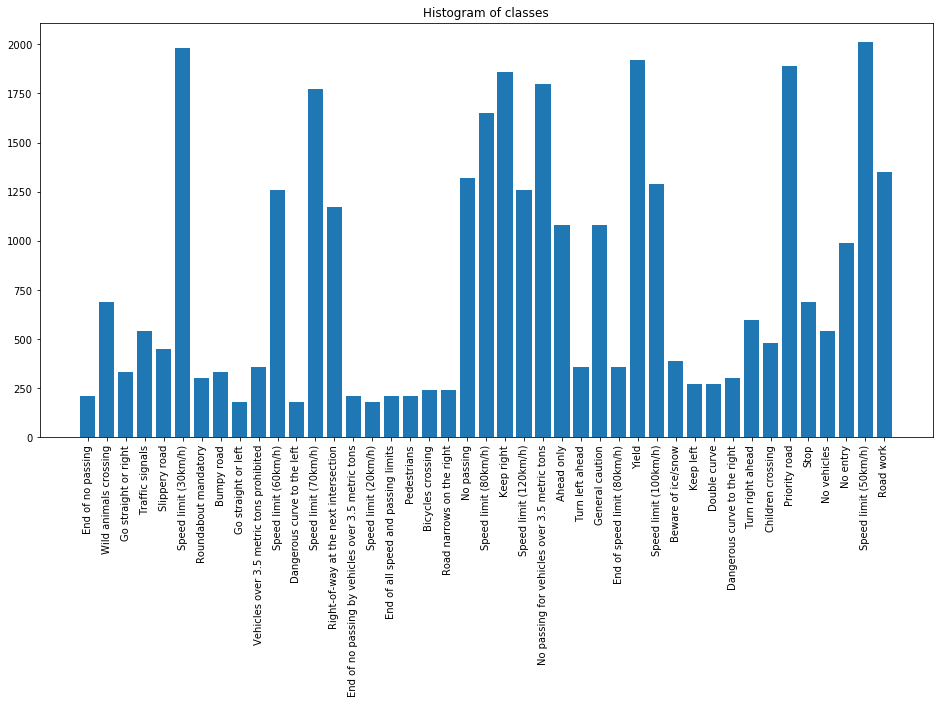

Visualization of training class frequencies after equalisation:


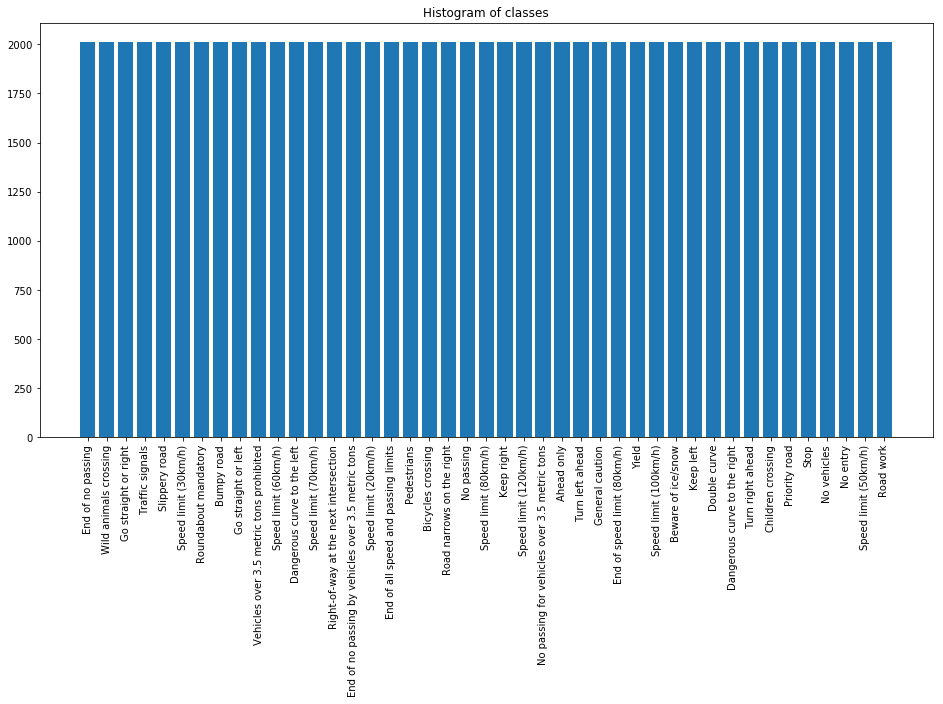

Visualization of validation class frequencies:


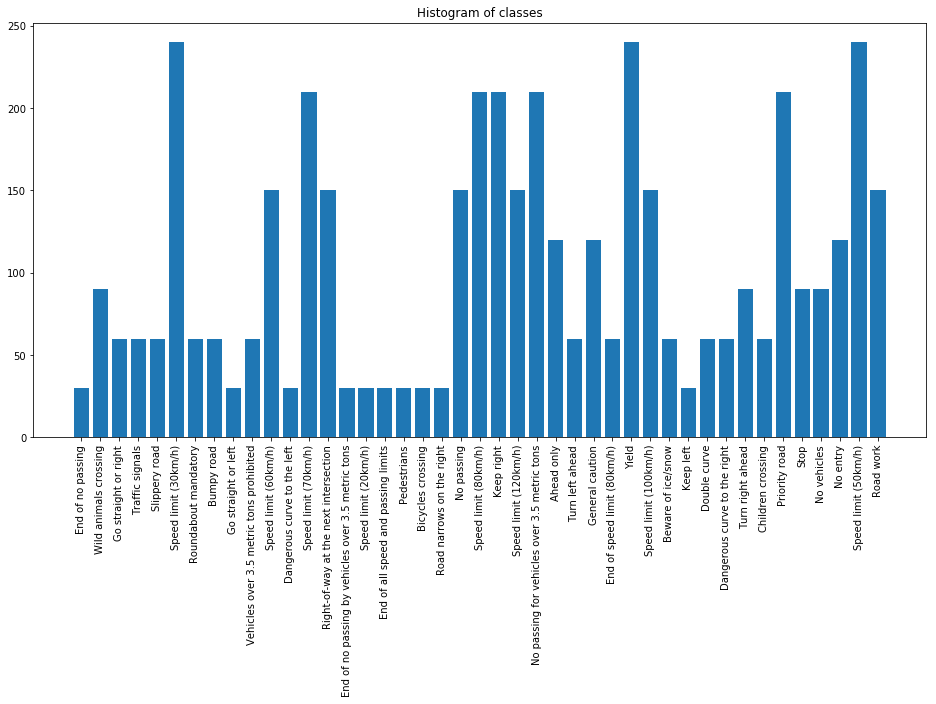

Visualization of some images of all classes:


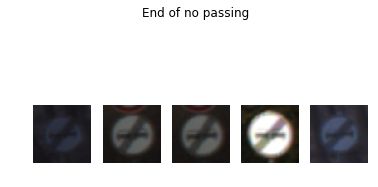

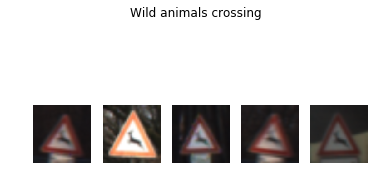

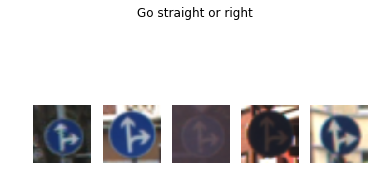

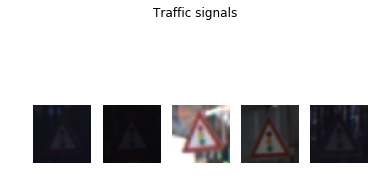

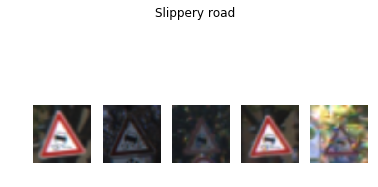

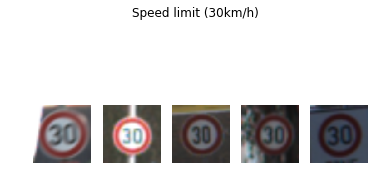

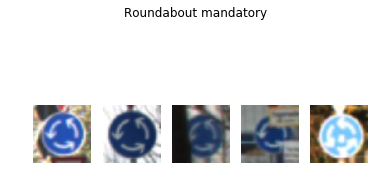

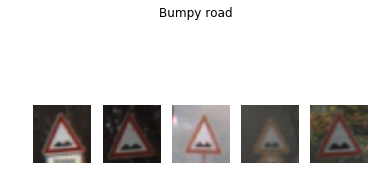

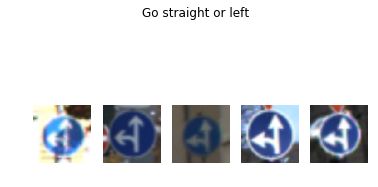

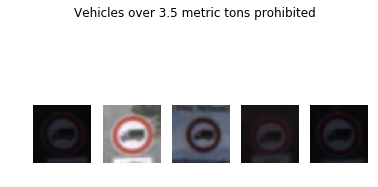

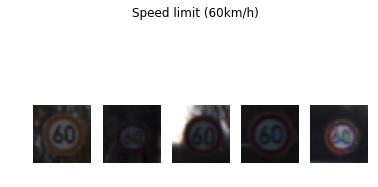

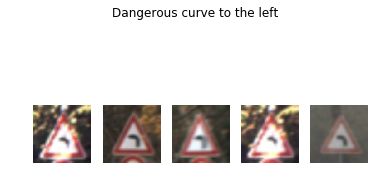

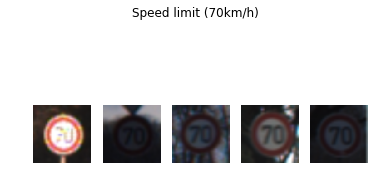

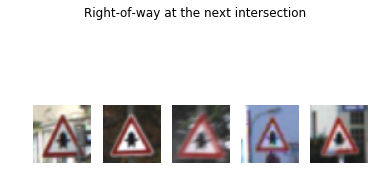

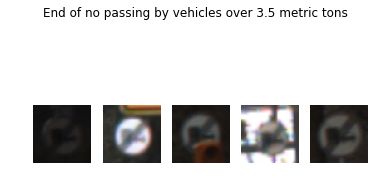

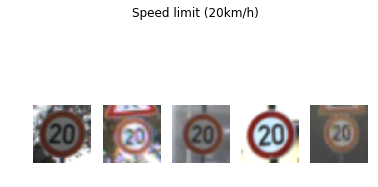

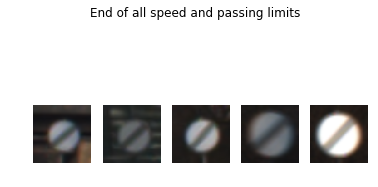

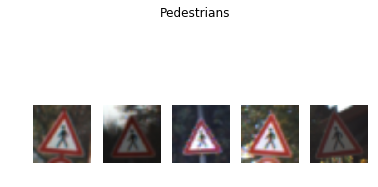

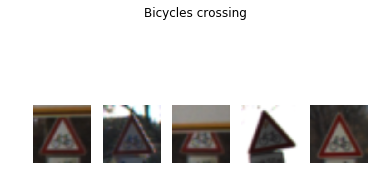

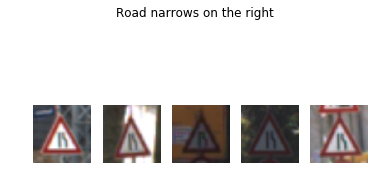

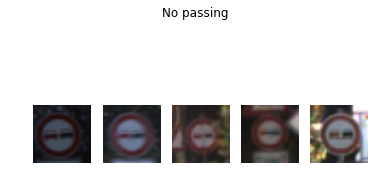

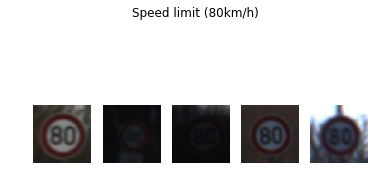

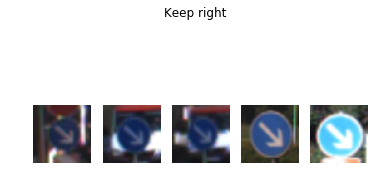

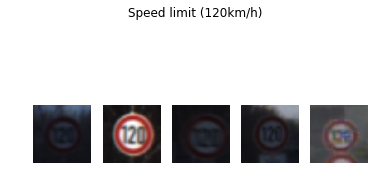

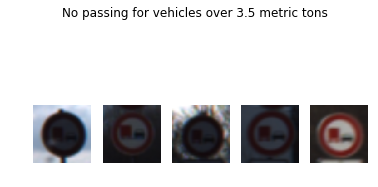

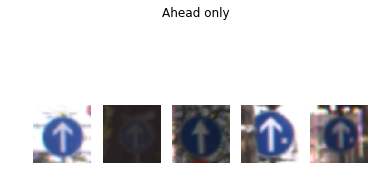

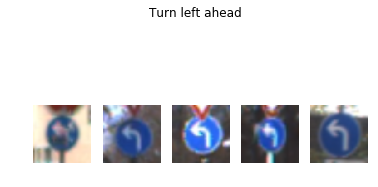

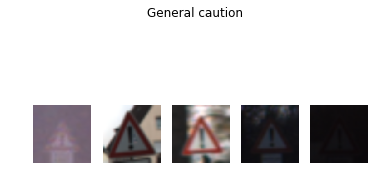

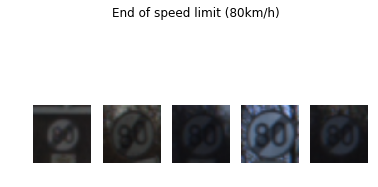

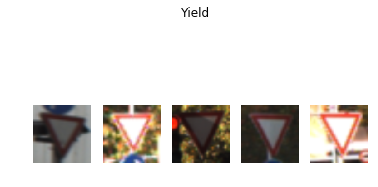

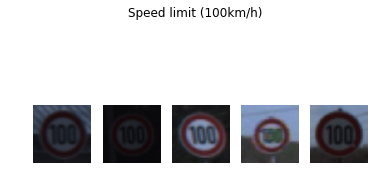

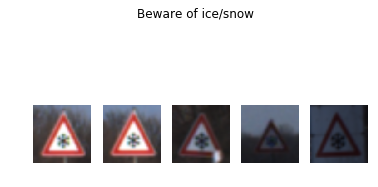

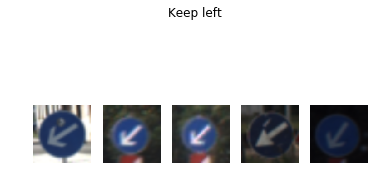

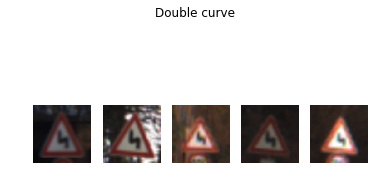

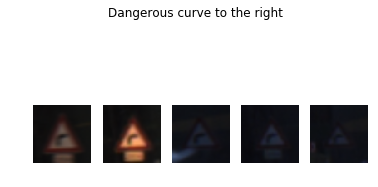

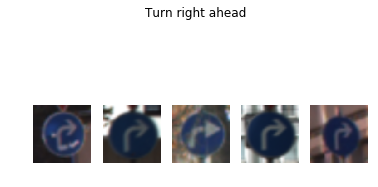

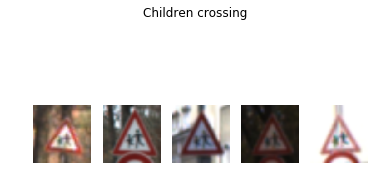

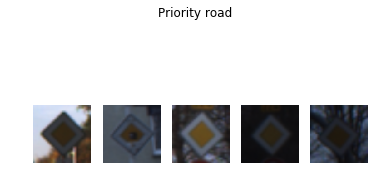

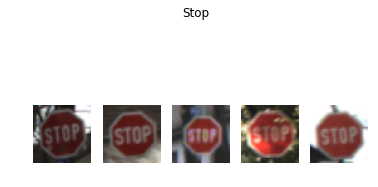

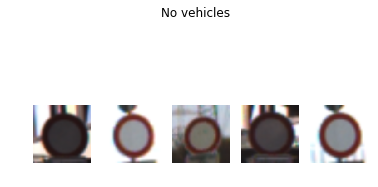

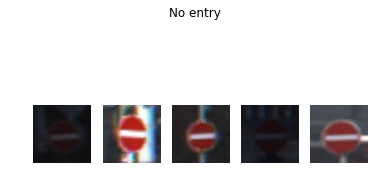

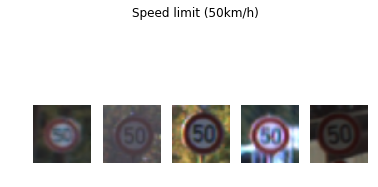

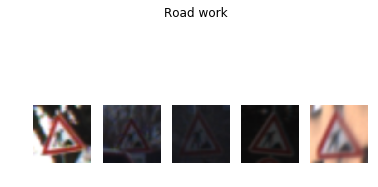

Visualization image augmentation:


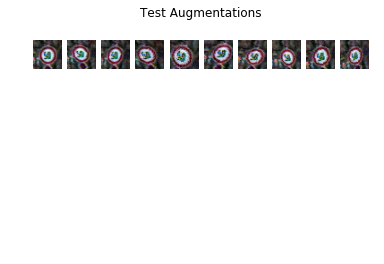

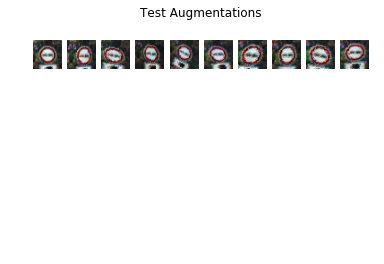

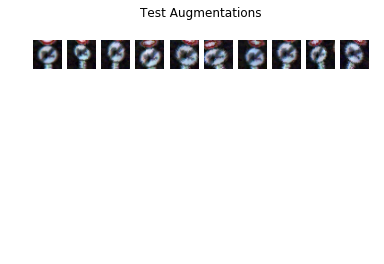

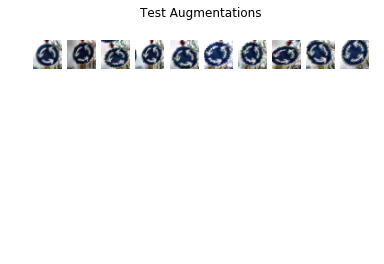

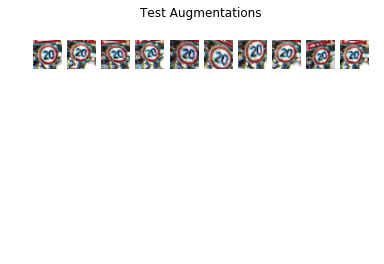

------------------------------
epoch  0
------------------------------


Loss decreased from  None  to  1.37985341741
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  2.75339898905  train_acc:  0.243590198896
valid_loss:  1.37985341741  valid_acc:  0.62154213701
------------------------------
epoch  1
------------------------------


Loss decreased from  1.37985341741  to  0.679247886022
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  1.4158113498  train_acc:  0.557678287958
valid_loss:  0.679247886022  valid_acc:  0.839285714286
------------------------------
epoch  2
------------------------------


Loss decreased from  0.679247886022  to  0.357438520226
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.901785927222  train_acc:  0.713649419301
valid_loss:  0.357438520226  valid_acc:  0.911383928571
------------------------------
epoch  3
------------------------------


Loss decreased from  0.357438520226  to  0.251530350186
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.65314741104  train_acc:  0.79419075873
valid_loss:  0.251530350186  valid_acc:  0.939732142857
------------------------------
epoch  4
------------------------------


Loss decreased from  0.251530350186  to  0.16218669582
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.524112153908  train_acc:  0.834646557403
valid_loss:  0.16218669582  valid_acc:  0.960267857143
------------------------------
epoch  5
------------------------------


Loss decreased from  0.16218669582  to  0.127583080504
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.428970231894  train_acc:  0.864239534692
valid_loss:  0.127583080504  valid_acc:  0.964508928571
------------------------------
epoch  6
------------------------------


Loss decreased from  0.127583080504  to  0.11705332056
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.394212945857  train_acc:  0.877380305792
valid_loss:  0.11705332056  valid_acc:  0.978348214286
------------------------------
epoch  7
------------------------------


Loss decreased from  0.11705332056  to  0.0988072751299
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.336289489806  train_acc:  0.894340637633
valid_loss:  0.0988072751299  valid_acc:  0.978571428571
------------------------------
epoch  8
------------------------------


Loss decreased from  0.0988072751299  to  0.0723682619991
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.305786089588  train_acc:  0.904948613004
valid_loss:  0.0723682619991  valid_acc:  0.984375
------------------------------
epoch  9
------------------------------


Loss decreased from  0.0723682619991  to  0.0703093033639
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.277311897782  train_acc:  0.912665545721
valid_loss:  0.0703093033639  valid_acc:  0.982589285714
------------------------------
epoch  10
------------------------------


Loss decreased from  0.0703093033639  to  0.0634151844736
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.255487254739  train_acc:  0.91887428984
valid_loss:  0.0634151844736  valid_acc:  0.984375
------------------------------
epoch  11
------------------------------


train_loss:  0.251569996424  train_acc:  0.920707825133
valid_loss:  0.0704376503545  valid_acc:  0.978125
------------------------------
epoch  12
------------------------------


Loss decreased from  0.0634151844736  to  0.0566937669648
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.224140454084  train_acc:  0.929770011674
valid_loss:  0.0566937669648  valid_acc:  0.982366071429
------------------------------
epoch  13
------------------------------


train_loss:  0.212728472837  train_acc:  0.936021056245
valid_loss:  0.0603505003965  valid_acc:  0.981473214286
------------------------------
epoch  14
------------------------------


Loss decreased from  0.0566937669648  to  0.0471877295732
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.210442973301  train_acc:  0.935437729692
valid_loss:  0.0471877295732  valid_acc:  0.986830357143
------------------------------
epoch  15
------------------------------


Loss decreased from  0.0471877295732  to  0.0453216459234
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.192323968855  train_acc:  0.939539814477
valid_loss:  0.0453216459234  valid_acc:  0.988169642857
------------------------------
epoch  16
------------------------------


train_loss:  0.19162179794  train_acc:  0.942154077484
valid_loss:  0.0527874616544  valid_acc:  0.986830357143
------------------------------
epoch  17
------------------------------


Loss decreased from  0.0453216459234  to  0.0338009363442
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.185663982445  train_acc:  0.942373934695
valid_loss:  0.0338009363442  valid_acc:  0.990178571429
------------------------------
epoch  18
------------------------------


train_loss:  0.171031946851  train_acc:  0.946409174405
valid_loss:  0.0462809925981  valid_acc:  0.984151785714
------------------------------
epoch  19
------------------------------


Loss decreased from  0.0338009363442  to  0.0299569623403
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.166262497345  train_acc:  0.949396306758
valid_loss:  0.0299569623403  valid_acc:  0.994642857143
------------------------------
epoch  20
------------------------------


train_loss:  0.162253842799  train_acc:  0.95157921117
valid_loss:  0.0370740498204  valid_acc:  0.9875
------------------------------
epoch  21
------------------------------


train_loss:  0.163044611526  train_acc:  0.949946732863
valid_loss:  0.0389595994608  valid_acc:  0.987276785714
------------------------------
epoch  22
------------------------------


train_loss:  0.155143182629  train_acc:  0.951320709332
valid_loss:  0.0312854837337  valid_acc:  0.990848214286
------------------------------
epoch  23
------------------------------


train_loss:  0.155154096908  train_acc:  0.953733393155
valid_loss:  0.0344354789455  valid_acc:  0.989732142857
------------------------------
epoch  24
------------------------------


Loss decreased from  0.0299569623403  to  0.0284255828013
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.147291995174  train_acc:  0.955059324775
valid_loss:  0.0284255828013  valid_acc:  0.990625
------------------------------
epoch  25
------------------------------


train_loss:  0.13600382254  train_acc:  0.958410448669
valid_loss:  0.0463726111601  valid_acc:  0.984151785714
------------------------------
epoch  26
------------------------------


train_loss:  0.139419199714  train_acc:  0.957113239476
valid_loss:  0.0434228936125  valid_acc:  0.985267857143
------------------------------
epoch  27
------------------------------


Loss decreased from  0.0284255828013  to  0.0282693385288
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.141450677587  train_acc:  0.956753947936
valid_loss:  0.0282693385288  valid_acc:  0.990401785714
------------------------------
epoch  28
------------------------------


train_loss:  0.134329636643  train_acc:  0.959698257858
valid_loss:  0.0484490172202  valid_acc:  0.981696428571
------------------------------
epoch  29
------------------------------


Loss decreased from  0.0282693385288  to  0.0240361490534
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.132410866386  train_acc:  0.960152594482
valid_loss:  0.0240361490534  valid_acc:  0.993080357143
------------------------------
epoch  30
------------------------------


train_loss:  0.131735172314  train_acc:  0.959999582128
valid_loss:  0.0261998402328  valid_acc:  0.991964285714
------------------------------
epoch  31
------------------------------


train_loss:  0.126183149665  train_acc:  0.962010151981
valid_loss:  0.0324325003002  valid_acc:  0.989285714286
------------------------------
epoch  32
------------------------------


Loss decreased from  0.0240361490534  to  0.0197826932329
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.127909418552  train_acc:  0.962211208966
valid_loss:  0.0197826932329  valid_acc:  0.994642857143
------------------------------
epoch  33
------------------------------


train_loss:  0.123256271931  train_acc:  0.962244631613
valid_loss:  0.0281385533099  valid_acc:  0.990848214286
------------------------------
epoch  34
------------------------------


train_loss:  0.121654670028  train_acc:  0.96382906507
valid_loss:  0.0251204135424  valid_acc:  0.990848214286
------------------------------
epoch  35
------------------------------


train_loss:  0.115406012666  train_acc:  0.963977899402
valid_loss:  0.0262858372017  valid_acc:  0.9921875
------------------------------
epoch  36
------------------------------


Loss decreased from  0.0197826932329  to  0.0168342401228
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.121027767295  train_acc:  0.962819080142
valid_loss:  0.0168342401228  valid_acc:  0.995089285714
------------------------------
epoch  37
------------------------------


train_loss:  0.112070713767  train_acc:  0.9663566386
valid_loss:  0.0328695131557  valid_acc:  0.9890625
------------------------------
epoch  38
------------------------------


train_loss:  0.117543555063  train_acc:  0.965404098525
valid_loss:  0.0292375364002  valid_acc:  0.990346961362
------------------------------
epoch  39
------------------------------


Loss decreased from  0.0168342401228  to  0.0139639638592
Saving Snapshot to  logs\final_experiment  ...
 


train_loss:  0.112419514443  train_acc:  0.965667300365
valid_loss:  0.0139639638592  valid_acc:  0.995982142857
------------------------------
epoch  40
------------------------------


train_loss:  0.112328885503  train_acc:  0.965648500139
valid_loss:  0.0254845140019  valid_acc:  0.991517857143
------------------------------
epoch  41
------------------------------


train_loss:  0.107119085117  train_acc:  0.968070583966
valid_loss:  0.0268909858521  valid_acc:  0.989508928571
------------------------------
epoch  42
------------------------------


train_loss:  0.106578118644  train_acc:  0.968357808231
valid_loss:  0.0261064841621  valid_acc:  0.991071428571
------------------------------
epoch  43
------------------------------


train_loss:  0.105602828656  train_acc:  0.96871187757
valid_loss:  0.0228401375848  valid_acc:  0.990848214286
------------------------------
epoch  44
------------------------------


train_loss:  0.108179679127  train_acc:  0.967960394481
valid_loss:  0.0196079970056  valid_acc:  0.994196428571
------------------------------
epoch  45
------------------------------


train_loss:  0.100575646413  train_acc:  0.969736484701
valid_loss:  0.0265482906404  valid_acc:  0.990625
------------------------------
epoch  46
------------------------------


train_loss:  0.10479678797  train_acc:  0.969492083087
valid_loss:  0.0185257919769  valid_acc:  0.993973214286
------------------------------
epoch  47
------------------------------


train_loss:  0.105785284907  train_acc:  0.969564150142
valid_loss:  0.0493084128456  valid_acc:  0.983035714286
------------------------------
epoch  48
------------------------------


train_loss:  0.101137813626  train_acc:  0.969851374407
valid_loss:  0.0282944094664  valid_acc:  0.989955357143
------------------------------
epoch  49
------------------------------


train_loss:  0.103723937372  train_acc:  0.969133313745
valid_loss:  0.016253844914  valid_acc:  0.9953125


Incorrect predictions:  21  /  4410


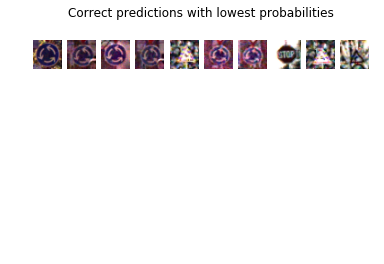

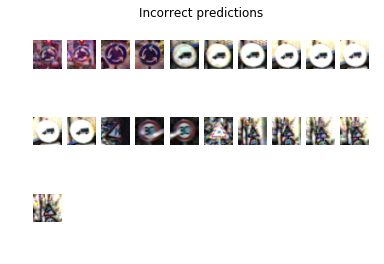

ValueError: Variable sq_conv3x3_1_weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)


In [9]:
# %load train_evaluate_trafficsign_clsf.py
import tensorflow as tf
import numpy as np
import os

import sklearn.utils as skutil
import packages.dataset_utils as util
import packages.tf_models as models
import packages.tf_train_utils as train_utils

# For creation of the custom traffic sign images dataset
# util.create_dataset('images/custom_signs', 'custom_test.p')


class ModelTrainer(object):
    def __init__(self, log_directory: str, path_to_traindata: str, path_to_valdata: str, translations_file: str):

        self._logdir = log_directory
        self._path_traindata = path_to_traindata
        self._path_valdata = path_to_valdata
        self._translations = translations_file

        self._training_set = None
        self._validation_set = None

        self._n_classes = None
        self._class_translations = None

        self.class_equalizer = None
        self.image_preprocessor = None
        self.image_augmenter = None

        # the later applied preprocessing function:
        self._preprocessing_function = None

        # the later applied augmentation function
        self._augmentation_function = None

        # the generators
        self._train_batch_generator = None
        self._valid_batch_generator = None

        # the training hyper parameters
        self._learning_rate = None
        self._momentum = None
        self._batch_size = None
        self._steps_per_epoch_train = None
        self._steps_per_epoch_valid = None
        self._epochs = None
        self._optimizer = None

        # the TensorFlow session
        self._session = None
        self._model = None
        self._train_saver = None

        # the output of our model
        self._model_predictions = None
        self._tf_graph_elements = None

        # init sequence
        self.__init_datasets()
        self.__init_dataset_equalizer()
        self.__init_image_preprocessor()
        self.__init_image_augmenter()

    def __init_datasets(self):
        # Initialize the training and validation datasets
        self._training_set = util.load_dataset(self._path_traindata)
        self._validation_set = util.load_dataset(self._path_valdata)

        # Read in the translations for the labels
        self._class_translations = util.load_translation_file(self._translations)

        # Set n_classes
        self._n_classes = len(np.unique(self._training_set[1]))

    def __init_dataset_equalizer(self):
        # Initialize the class, responsible for class frequencies
        self.class_equalizer = train_utils.ClassEqualizer(self._training_set[0],
                                                          self._training_set[1])

    def __init_image_preprocessor(self):
        assert self._training_set
        # Initialize the ImageProcessor with the raw image data
        self.image_preprocessor = train_utils.ImagePreprocessor(self._training_set[0])

    def __init_image_augmenter(self):
        # The arguments for the basic data augmenter may also be arguments for
        # the ModelTrainer for iterative hyper parameter search !
        self.image_augmenter = train_utils.BasicDataAugmenter(rotation_range=20,
                                                              width_shift_range=0.1,
                                                              height_shift_range=0.1,
                                                              intensity_shift=0.75,
                                                              shear_range=0.2,
                                                              zoom_range=0.2)

    def __init_batch_generators(self):
        # This function will initialize the batch generators for training and validation
        assert self._batch_size
        assert self._n_classes
        assert self._training_set
        assert self._validation_set

        self._train_batch_generator = train_utils.BatchGenerator(batch_size=self._batch_size,
                                                                 n_classes=self._n_classes,
                                                                 x_list=self._training_set[0],
                                                                 y_list=self._training_set[1],
                                                                 augmentation_fn=self._augmentation_function,
                                                                 preprocessing_fn=self._preprocessing_function,
                                                                 shuffle=True)

        self._valid_batch_generator = train_utils.BatchGenerator(batch_size=self._batch_size,
                                                                 n_classes=self._n_classes,
                                                                 x_list=self._validation_set[0],
                                                                 y_list=self._validation_set[1],
                                                                 preprocessing_fn=self._preprocessing_function,
                                                                 shuffle=False)

    def get_image_shape(self):
        assert self._training_set
        assert len(self._training_set[0]) > 0
        return self._training_set[0][-1].shape

    def get_num_classes(self):
        assert self._n_classes
        return self._n_classes

    def equalize_traindata_class_frequencies(self):
        # Make sure that every class occurrence-probability is nearly equal
        assert self.class_equalizer
        assert self._training_set

        # Fill images up with random samples
        self._training_set[0], self._training_set[1] = self.class_equalizer.fill_up_with_copies()

    def set_preprocessing_function(self, preprocessing_function):
        self._preprocessing_function = preprocessing_function

    def set_augmentation_function(self, augmentation_function):
        self._augmentation_function = augmentation_function

    def set_training_parameter(self,
                               learning_rate: float=1e-3,
                               momentum: float=0.9,
                               batch_size: int=128,
                               epochs: int=50,
                               optimizer: str='adam'):
        self._learning_rate = learning_rate
        self._momentum = momentum
        self._batch_size = batch_size
        self._epochs = epochs
        self._steps_per_epoch_train = int(np.ceil(len(self._training_set[0]) / float(batch_size)))
        self._steps_per_epoch_valid = int(np.ceil(len(self._validation_set[0]) / float(batch_size)))

        if optimizer not in ['adam', 'sgd']:
            raise Exception('Unrecognized optimizer, try adam or sgd.')

        if optimizer == 'adam':
            self._optimizer = train_utils.adam_optimizer(self._learning_rate)

        if optimizer == 'sgd':
            self._optimizer = train_utils.sgd_optimizer(self._learning_rate, self._momentum)

        # At this point we are ready for initialization of the batch generators
        self.__init_batch_generators()

    def set_model(self, model: models.TfModel):
        # Get the traindata image shape
        input_shape = self.get_image_shape()

        # Remember the model
        self._model = model

        # Build a dictionary with TensorFlow graph - nodes
        self._tf_graph_elements = {}

        # x is the placeholder for a batch of images
        x = tf.placeholder(shape=[None,
                                  input_shape[0],
                                  input_shape[1],
                                  input_shape[2]],
                           dtype=tf.float32)

        # y is the placeholder for a batch of labels
        y = tf.placeholder(shape=[None], dtype=tf.int32)

        # The x placeholder
        self._tf_graph_elements.update({'x': x})

        # The y placeholder
        self._tf_graph_elements.update({'y': y})

        # The model dropout placeholder
        self._tf_graph_elements.update({'dropout': model.dropout_keep_prob_placeholder})

        # The One-Hot encoded y
        self._tf_graph_elements.update({'y_one_hot': tf.one_hot(y, self._n_classes)})

        # Set model_predictions to the output of the model
        self._tf_graph_elements.update({'model_predictions': model.construct(x)})

        # The proper probabilities are the logits with softmax-function applied
        self._model_predictions = tf.nn.softmax(self._tf_graph_elements['model_predictions'])

        # Define the loss function op
        self._tf_graph_elements.update({'loss': train_utils.cross_entropy_loss(
            self._tf_graph_elements['model_predictions'],
            self._tf_graph_elements['y_one_hot'])})

        # Define the acc function op
        self._tf_graph_elements.update({'acc': train_utils.accuracy(
            self._tf_graph_elements['model_predictions'],
            self._tf_graph_elements['y_one_hot'])})

        # Define the evaluation function op
        self._tf_graph_elements.update({'evaluate': train_utils.evaluation(
            self._tf_graph_elements['model_predictions'],
            self._tf_graph_elements['y_one_hot'])})

        # Define the optimizer op
        self._tf_graph_elements.update({'target_op': self._optimizer.minimize(self._tf_graph_elements['loss'])})

        # Instantiate the TF Session
        self._session = tf.Session()

        # Initialize all variables
        self._session.run(tf.global_variables_initializer())

    def load_weights(self, path: str):
        saver = tf.train.Saver()
        saver.restore(self._session, path)

    def get_last_checkpoint_filename(self):
        return self._train_saver.last_checkpoint

    def fit(self, experiment_name: str):
        """
        In this function, all components will come together for training the model.
        :param experiment_name: Is the current experiment name
        :param display_most_unsure: After training the n most unsure correct samples are shown.
        """
        assert self._session

        log_dir = os.path.join(self._logdir, experiment_name)

        # Creating some history container
        train_loss_history = []
        train_acc_history = []

        validation_loss_history = []
        validation_acc_history = []

        # Build the TrainSaver
        self._train_saver = train_utils.TrainSaver(directory=log_dir)

        # Create summaries for this run
        summaries = ['train_loss', 'train_acc', 'val_loss', 'val_acc']
        summary_placeholder = []
        summary_ops = []

        for s in summaries:
            summary_placeholder.append(tf.placeholder(dtype=tf.float32))
            summary_ops.append(tf.summary.scalar(s, summary_placeholder[-1]))

        # Initialize a Tensorboard summary Writer
        summary_writer = tf.summary.FileWriter(logdir=log_dir, graph=self._session.graph)

        # Run over epochs
        for epoch in range(self._epochs):
            print('------------------------------')
            print('epoch ', epoch)
            print('------------------------------')

            train_loss = 0
            train_acc = 0
            valid_loss = 0
            valid_acc = 0

            # Iterate n steps until one complete epoch was shown to the network
            for i in range(self._steps_per_epoch_train):
                # Get the batch from training batch generator
                batch_x, batch_y = self._train_batch_generator.next()

                # Prepare the graph nodes to run and the graph inputs
                ops_to_run = [self._tf_graph_elements['target_op'],
                              self._tf_graph_elements['loss'],
                              self._tf_graph_elements['acc']]

                feed_dict = {self._tf_graph_elements['x']: batch_x,
                             self._tf_graph_elements['y']: batch_y,
                             self._tf_graph_elements['dropout']: self._model.dropout_training_value}

                # Run a optimizer step
                _, current_train_loss, current_train_acc = self._session.run(ops_to_run, feed_dict=feed_dict)

                train_loss += current_train_loss
                train_acc += current_train_acc

            # Iterate n steps for the validation now
            for j in range(self._steps_per_epoch_valid):
                # Get the batch from training batch generator
                batch_x, batch_y = self._valid_batch_generator.next()

                # Prepare the graph nodes to run and the graph inputs
                ops_to_run = [self._tf_graph_elements['loss'],
                              self._tf_graph_elements['acc']]

                feed_dict = {self._tf_graph_elements['x']: batch_x,
                             self._tf_graph_elements['y']: batch_y,
                             self._tf_graph_elements['dropout']: 1.0}

                # Just get the loss and accuracy over this batch
                current_val_loss, current_acc = self._session.run(ops_to_run, feed_dict=feed_dict)

                valid_loss += current_val_loss
                valid_acc += current_acc

            # Remember the history of this run
            train_loss_history.append(train_loss / self._steps_per_epoch_train)
            train_acc_history.append(train_acc / self._steps_per_epoch_train)

            validation_loss_history.append(valid_loss / self._steps_per_epoch_valid)
            validation_acc_history.append(valid_acc / self._steps_per_epoch_valid)

            # Record this snapshot
            self._train_saver.record(session=self._session, step=epoch, loss=validation_loss_history[-1])

            # I like Tensorboard !
            feed_dict = {summary_placeholder[0]: train_loss_history[-1],
                         summary_placeholder[1]: train_acc_history[-1],
                         summary_placeholder[2]: validation_loss_history[-1],
                         summary_placeholder[3]: validation_acc_history[-1]}

            tf_summaries = self._session.run(tf.summary.merge(summary_ops), feed_dict=feed_dict)
            summary_writer.add_summary(tf_summaries, epoch)

            # Print to Console, too
            print('train_loss: ', train_loss_history[-1],
                  ' train_acc: ', train_acc_history[-1])

            print('valid_loss: ', validation_loss_history[-1],
                  ' valid_acc: ', validation_acc_history[-1])

    def evaluation_run(self, display_most_unsure: int=10, detailed_view=False):
        assert self._session

        # I run through the validation dataset to create a set of statistics about the trained model
        self._valid_batch_generator.reset()

        # 1. Remember the n correct results with lowest probability ( n = validation_save_worst_n_correct )
        # 2. Remember all incorrect classifications
        worst_n_correct_predictions = {}
        incorrect_predictions = {}

        for step in range(self._steps_per_epoch_valid):
            # Get the batch from training batch generator
            # This will yield exactly 1 Sample
            batch_x, batch_y = self._valid_batch_generator.next()

            # Prepare the graph nodes to run and the graph inputs
            ops_to_run = [self._tf_graph_elements['evaluate']]

            feed_dict = {self._tf_graph_elements['x']: batch_x,
                         self._tf_graph_elements['y']: batch_y,
                         self._tf_graph_elements['dropout']: 1.0}

            # Just get the loss and accuracy over this batch
            eval_results = self._session.run(ops_to_run, feed_dict=feed_dict)

            # Iterate through the batch of results
            for eval_hits, eval_probs in eval_results:
                for hit_idx, eval_hit in enumerate(eval_hits):
                    hit = eval_hit
                    probabilities = eval_probs[hit_idx]
                    prob_of_correct_label = probabilities[batch_y[hit_idx]]

                    if detailed_view:
                        predictions_dict = {}
                        for label_idx, pred in enumerate(eval_probs[hit_idx]):
                            predictions_dict.update({self._class_translations[label_idx]: pred})

                        util.visualize_single_prediction(img=batch_x[hit_idx],
                                                         title=self._class_translations[batch_y[hit_idx]],
                                                         predictions=predictions_dict)

                    if not hit:
                        incorrect_predictions.update(
                            {len(incorrect_predictions): [batch_x[hit_idx],
                                                          self._class_translations[batch_y[hit_idx]],
                                                          prob_of_correct_label]})

                    else:
                        # If the model hit the correct class,
                        # remember the probability and update the worst_n_correct_preds
                        max_prob_k = None
                        max_prob = 0.0
                        for k in worst_n_correct_predictions:
                            if worst_n_correct_predictions[k][2] > max_prob:
                                max_prob = worst_n_correct_predictions[k][2]
                                max_prob_k = k

                        insert_item = False
                        if max_prob_k is None or len(worst_n_correct_predictions) < display_most_unsure:
                            max_prob_k = len(worst_n_correct_predictions)
                            insert_item = True

                        insert_item = insert_item or (max_prob > prob_of_correct_label)

                        if insert_item:
                            worst_n_correct_predictions.update(
                                {max_prob_k: [batch_x[hit_idx],
                                              self._class_translations[batch_y[hit_idx]],
                                              prob_of_correct_label]})

        print('Incorrect predictions: ', str(len(incorrect_predictions)), ' / ', str(len(self._validation_set[0])))
        util.visualize_predictions(worst_n_correct_predictions, 'Correct predictions with lowest probabilities')
        util.visualize_predictions(incorrect_predictions, 'Incorrect predictions')

    def print_dataset_statistics(self, dataset_name: str='train'):
        if dataset_name not in ['train', 'val']:
            raise Exception('Unrecognized dataset name! Try train or val.')

        dataset = self._training_set if dataset_name == 'train' else self._validation_set
        util.print_datasets_stats(dataset[0], dataset[1])

    def visualize_dataset_images(self, dataset_name: str='train', samples_per_class: int=5):
        if dataset_name not in ['train', 'val']:
            raise Exception('Unrecognized dataset name! Try train or val.')

        dataset = self._training_set if dataset_name == 'train' else self._validation_set

        util.visualize_dataset_content(dataset[0],
                                       dataset[1],
                                       self._class_translations,
                                       n_samples=samples_per_class)

    def visualize_dataset_frequencies(self, dataset_name: str='train'):
        if dataset_name not in ['train', 'val']:
            raise Exception('Unrecognized dataset name! Try train or val.')

        dataset = self._training_set if dataset_name == 'train' else self._validation_set

        util.visualize_dataset_frequencies(dataset[1],
                                           self._class_translations)

    def visualize_image_augmentation(self, k_samples: int=5, k_augmentations: int=9):
        # Sample k training-samples, augment them and display the results
        augment_x, augment_y = skutil.resample(self._training_set[0],
                                               self._training_set[1],
                                               n_samples=k_samples)

        for k_s in range(k_samples):
            augmentations = {}

            # Push in the original
            augmentations.update({len(augmentations): [self._preprocessing_function(augment_x[k_s]),
                                                       self._class_translations[augment_y[k_s]],
                                                       0.0]})

            for k_a in range(k_augmentations):
                augmentations.update({len(augmentations): [self._preprocessing_function(
                    self._augmentation_function(augment_x[k_s])),
                    self._class_translations[augment_y[k_s]],
                    0.0]})

            util.visualize_predictions(augmentations, 'Test Augmentations')


# Train a model
# ---------------------------------------------------------------------------------------------------------

# Instantiate the ModelTrainer !
trainer = ModelTrainer(log_directory='logs',
                       path_to_traindata='datasets/train.p',
                       path_to_valdata='datasets/valid.p',
                       translations_file='signnames.csv')

# The preprocessing function will be a lambda function that calls some functions of the image_preprocessor
trainer.set_preprocessing_function((lambda x: trainer.image_preprocessor.normalize_center(
    trainer.image_preprocessor.apply_clahe(x))))

# The augmentation function is also a lambda function that uses the internal image augmenter of the ModelTrainer
trainer.set_augmentation_function((lambda x: trainer.image_augmenter.process(x)))

# Set the parameter of this training process.
trainer.set_training_parameter(learning_rate=1e-3, batch_size=128, epochs=50, optimizer='adam')

# Print out some information about the datasets
print('Training set statistics:')
trainer.print_dataset_statistics(dataset_name='train')

print('Validation set statistics:')
trainer.print_dataset_statistics(dataset_name='val')

# Print frequencies
print('Visualization of training class frequencies:')
trainer.visualize_dataset_frequencies(dataset_name='train')

# Print frequencies after equalisation
trainer.equalize_traindata_class_frequencies()
print('Visualization of training class frequencies after equalisation:')
trainer.visualize_dataset_frequencies(dataset_name='train')

# Print frequencies
print('Visualization of validation class frequencies:')
trainer.visualize_dataset_frequencies(dataset_name='val')

# Visualize some images
print('Visualization of some images of all classes:')
trainer.visualize_dataset_images(dataset_name='train')

# Visualize Augmentation
print('Visualization image augmentation:')
trainer.visualize_image_augmentation()

# Get the shape of the training images
input_shape = trainer.get_image_shape()

# Get the count of classes from the ModelTrainer
num_classes = trainer.get_num_classes()

# Define the model to train
custom_squeezenet = models.TfCustomSqueezeNet(input_shape=[None,
                                                           input_shape[0],
                                                           input_shape[1],
                                                           input_shape[2]],
                                              n_classes=num_classes,
                                              kernel_regularization=0.01,
                                              dropout_training_value=0.5)
# Set the model to the ModelTrainer
trainer.set_model(custom_squeezenet)

# Fit the model with the specified optimizer to the training set
trainer.fit(experiment_name='final_experiment')

# Evaluate on the validation set
trainer.evaluation_run(display_most_unsure=10, detailed_view=False)

# Get the last (best) Checkpoint filename
last_checkpoint = trainer.get_last_checkpoint_filename()


# Load a model and evaluate the test-set
# ---------------------------------------------------------------------------------------------------------

# Instantiate the ModelTrainer !
trainer = ModelTrainer(log_directory='logs',
                       path_to_traindata='datasets/train.p',
                       path_to_valdata='datasets/test.p',
                       translations_file='signnames.csv')

# The preprocessing function will be a lambda function that calls some functions of the image_preprocessor
trainer.set_preprocessing_function((lambda x: trainer.image_preprocessor.normalize_center(
    trainer.image_preprocessor.apply_clahe(x))))

# The augmentation function is also a lambda function that uses the internal image augmenter of the ModelTrainer
trainer.set_augmentation_function((lambda x: trainer.image_augmenter.process(x)))

# Set the parameter of this training process.
trainer.set_training_parameter(learning_rate=1e-3, batch_size=128, epochs=50, optimizer='adam')

# Get the shape of the training images
input_shape = trainer.get_image_shape()

# Get the count of classes from the ModelTrainer
num_classes = trainer.get_num_classes()

# Define the model to train
custom_squeezenet = models.TfCustomSqueezeNet(input_shape=[None,
                                                           input_shape[0],
                                                           input_shape[1],
                                                           input_shape[2]],
                                              n_classes=num_classes,
                                              kernel_regularization=0.01,
                                              dropout_training_value=0.5)
# Set the model to the ModelTrainer
trainer.set_model(custom_squeezenet)

# Load the last checkpoint from previous training
trainer.load_weights(last_checkpoint)

# Evaluate on the validation set
trainer.evaluation_run(display_most_unsure=10, detailed_view=False)


# Load a model and evaluate the custom test-set
# ---------------------------------------------------------------------------------------------------------

# Instantiate the ModelTrainer !
trainer = ModelTrainer(log_directory='logs',
                       path_to_traindata='datasets/train.p',
                       path_to_valdata='datasets/custom_test.p',
                       translations_file='signnames.csv')

# The preprocessing function will be a lambda function that calls some functions of the image_preprocessor
trainer.set_preprocessing_function((lambda x: trainer.image_preprocessor.normalize_center(
    trainer.image_preprocessor.apply_clahe(x))))

# The augmentation function is also a lambda function that uses the internal image augmenter of the ModelTrainer
trainer.set_augmentation_function((lambda x: trainer.image_augmenter.process(x)))

# Set the parameter of this training process.
trainer.set_training_parameter(learning_rate=1e-3, batch_size=128, epochs=50, optimizer='adam')

# Get the shape of the training images
input_shape = trainer.get_image_shape()

# Get the count of classes from the ModelTrainer
num_classes = trainer.get_num_classes()

# Define the model to train
custom_squeezenet = models.TfCustomSqueezeNet(input_shape=[None,
                                                           input_shape[0],
                                                           input_shape[1],
                                                           input_shape[2]],
                                              n_classes=num_classes,
                                              kernel_regularization=0.01,
                                              dropout_training_value=0.5)
# Set the model to the ModelTrainer
trainer.set_model(custom_squeezenet)

# Load the last checkpoint from previous training
trainer.load_weights(last_checkpoint)

# Evaluate on the validation set
trainer.evaluation_run(display_most_unsure=10, detailed_view=True)




### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [ ]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = ?

# TODO: Number of validation examples
n_validation = ?

# TODO: Number of testing examples.
n_test = ?

# TODO: What's the shape of an traffic sign image?
image_shape = ?

# TODO: How many unique classes/labels there are in the dataset.
n_classes = ?

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [ ]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [1]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")